In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from typing import Annotated,Literal,Sequence,TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import START,StateGraph,END

c:\agentic_rag\venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
## laoding the cloud api in my local system
## which are required during the devolpment of this project
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm = ChatGroq(model_name = "Gemma2-9b-It")
                                   

In [7]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [11]:
## this is content
docs = [WebBaseLoader(url).load() for url in urls]

In [12]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [ ]:
## now the text data is in nested list
## i wnat my data in single list , not in nested list

In [14]:
documents = [d for url in docs for d in url]

In [15]:
print(documents)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [90]:
documents

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
## till here i have the documents
## now my next task is to convert this text data into word vector embeddings and then store the whole word vector embeddings in vector database
## here i will be using chromadb as my vector database

In [91]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size =200,chunk_overlap=50)
docs_split = text_splitter.split_documents(documents)

In [20]:
vectorstore = Chroma.from_documents(
    documents=docs_split,
    embedding=embeddings,
    collection_name="rag-chrome"
)

In [63]:
## now creating retrieve on top of this retriever
retriever = vectorstore.as_retriever()

In [64]:
retriever.invoke("what is prompt engineering")

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the mode

In [23]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriever",
    "search and return information about ai agents,llm ,prompt engineering and agentic ai related queries"
)

In [25]:
tools = [retriever_tool]

In [26]:
retrieve = ToolNode(tools) ## this is a retriver node which will be linked with llm

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [58]:
## now i will be writting the code for main ai assistant
## this ai assistant will be in top of the graph
def AI_Assistant(state:AgentState):
    messages = state["messages"]
    if len(messages)>1: ## means the question is coming to ai assistant again or after the query rewriter, so now i need to simply generate the response of this question
        question = messages[-1].content
        prompt = PromptTemplate(
            template = """ You are a helpful assistant whatever question is given to you , you will give answer of that question very 
            carefully.here is the question:{question}
                             """,
           input_variables=["question"]
        )

        chain = prompt | llm
        response = chain.invoke(question)
        return {"messages":[response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        messages = state["messages"]
        question = messages[-1].content
        response = llm_with_tool.invoke(question)
        return {"messages":[response]}

In [29]:
class Grade(BaseModel):
    binary_score:str = Field(description="gives relevence score 'yes' or 'no' ")

In [31]:
def grade_documents(state:AgentState):
    messages = state["messages"]
    question = messages[0].content
    documents = messages[-1].content
    
    prompt = PromptTemplate(
        template = """ You are a helpful assistant.Given the question and document to you.
        You need to find out that the provided question is relevant to documents or not.You need to see it carefully.
        if the question is relevant to the documents return 'yes' and if the question is not relevant to the documents
        then return 'no'
        The question is:{question} and the documents:{documents} 

                       """,
        input_variables=["question","documents"]
        

    )

    llm_structured = llm.with_structured_output(Grade)
    chain = prompt | llm_structured
    binary_score = chain.invoke({"question":question,"documents":documents})
    if binary_score.binary_score == 'yes':
        return 'generate'
    else:
        return 'question_rewriter'

In [35]:
def generate(state:AgentState):
    messages = state["messages"]
    question = messages[0].content
    documents = messages[-1].content

    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({"question":question,"context":documents})
    return {"messages":[response]}


In [ ]:
## the generate function was for the first condition
## that question is relevant to the fectched documents
## but now assume the question is not relevant to the fetched dcouments
## in that case we will send the question to document rewriter
## so let us creating python function for document rewriter

In [38]:
def question_rewriter(state:AgentState):
    messages = state["messages"]
    question = messages[0].content

    prompt = PromptTemplate(
        template = """ You are a helpful assistant. You will be given a question.Your job is to know the intention of the question.
        then update the question . do not add extra thing while upodating the question, if you are not able to update the question leave it as it is.
        the question is:{question}
                           """,
        input_variables=["question"]

    )

    chain = prompt|llm
    response = chain.invoke({"question":question})
    return {"messages":[response]}

In [80]:
workflow = StateGraph(AgentState)
## defining nodes of the graph
workflow.add_node("AI_ASSISTANT",AI_Assistant)
workflow.add_node("retriever",retrieve)
workflow.add_node("generate",generate)
workflow.add_node("question_rewriter",question_rewriter)
## now after defining all the nodes mow i need to join all the nodes
workflow.add_edge(START,"AI_ASSISTANT")
workflow.add_conditional_edges("AI_ASSISTANT",tools_condition,{"tools":"retriever",END:END})
workflow.add_conditional_edges("retriever",grade_documents,{"generate":"generate","question_rewriter":"question_rewriter"})
workflow.add_edge("question_rewriter","AI_ASSISTANT")
workflow.add_edge("generate",END)

app = workflow.compile()

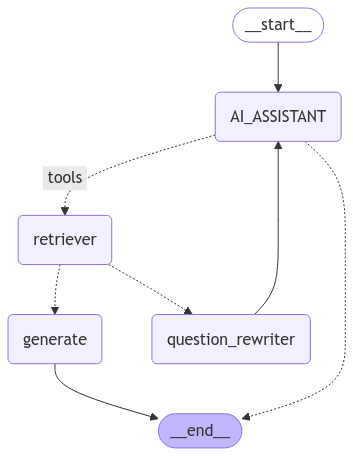

In [81]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [89]:
app.invoke({"messages":["What is a Autonomous Agent?"]})["messages"][-1].content ## this will be the final response my chatbot will provide

'An autonomous agent is a system, often powered by a large language model (LLM), that can act independently to achieve a goal.  These agents plan their actions, react to their environment, and can even consider the actions and observations of other agents.  LLM-powered autonomous agents are a growing area of research with the potential for many applications. \n\n\n'

In [87]:
app.invoke({"messages":["who is pm of India"]})["messages"][-1].content

'The current Prime Minister of India is **Narendra Modi**.  \n'